In [1]:
!pip install 'zarr<3'
!pip install timm


Defaulting to user installation because normal site-packages is not writeable
  Using cached zarr-2.18.7-py3-none-any.whl.metadata (5.8 kB)
  Using cached asciitree-0.3.3-py3-none-any.whl
  Using cached fasteners-0.20-py3-none-any.whl.metadata (4.8 kB)
  Using cached numcodecs-0.15.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.9 kB)
  Using cached deprecated-1.3.1-py2.py3-none-any.whl.metadata (5.9 kB)
Using cached zarr-2.18.7-py3-none-any.whl (211 kB)
Using cached numcodecs-0.15.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.9 MB)
Using cached fasteners-0.20-py3-none-any.whl (18 kB)
Using cached deprecated-1.3.1-py2.py3-none-any.whl (11 kB)

[notice] A new release of pip is available: 23.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
  Using cached timm-1.0.24-py3-none-any.whl.metadata (38 kB)
Using cached timm-1.0.24-py3-none-any.whl (2.6 MB)

[not

In [1]:
# ALWAYS RUN THIS FIRST!
import os
import sys
from pathlib import Path

NOTEBOOK_DIR = Path("/rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest")
os.chdir(NOTEBOOK_DIR)
sys.path.insert(0, str(NOTEBOOK_DIR))

print(f"✅ Working directory: {os.getcwd()}")

✅ Working directory: /rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest


## Load Monuseg

Found 14 images in /rsrch9/home/plm/idso_fa1_pathology/TIER1/yasin-vitaminp/public-datasets/MoNuSegTestData
✓ TCGA-2Z-A9J9-01A-01-TS1.tif: shape=(1000, 1000, 3), nuclei=575
✓ TCGA-44-2665-01B-06-BS6.tif: shape=(1000, 1000, 3), nuclei=818
✓ TCGA-69-7764-01A-01-TS1.tif: shape=(1000, 1000, 3), nuclei=441
✓ TCGA-A6-6782-01A-01-BS1.tif: shape=(1000, 1000, 3), nuclei=441
✓ TCGA-AC-A2FO-01A-01-TS1.tif: shape=(1000, 1000, 3), nuclei=521
✓ TCGA-AO-A0J2-01A-01-BSA.tif: shape=(1000, 1000, 3), nuclei=356
✓ TCGA-CU-A0YN-01A-02-BSB.tif: shape=(1000, 1000, 3), nuclei=677
✓ TCGA-EJ-A46H-01A-03-TSC.tif: shape=(1000, 1000, 3), nuclei=466
✓ TCGA-FG-A4MU-01B-01-TS1.tif: shape=(1000, 1000, 3), nuclei=465
✓ TCGA-GL-6846-01A-01-BS1.tif: shape=(1000, 1000, 3), nuclei=355
✓ TCGA-HC-7209-01A-01-TS1.tif: shape=(1000, 1000, 3), nuclei=325
✓ TCGA-HT-8564-01Z-00-DX1.tif: shape=(1000, 1000, 3), nuclei=249
✓ TCGA-IZ-8196-01A-01-BS1.tif: shape=(1000, 1000, 3), nuclei=533
✓ TCGA-ZF-A9R5-01A-01-TS1.tif: shape=(1000, 100

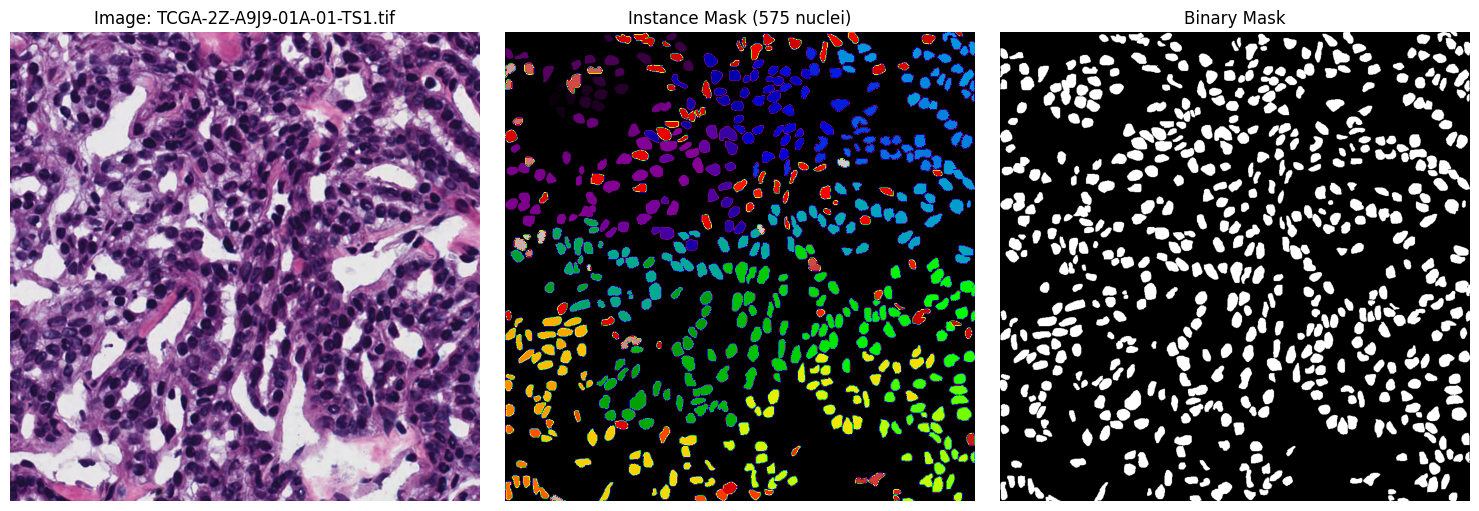

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import cv2
import xml.etree.ElementTree as ET

# Dataset path
monuseg_path = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER1/yasin-vitaminp/public-datasets/MoNuSegTestData")

def parse_monuseg_xml(xml_path, image_shape):
    """Parse MoNuSeg XML annotation file and convert to instance mask"""
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    # Create blank mask
    mask = np.zeros(image_shape[:2], dtype=np.uint16)
    
    # Parse each region (nucleus)
    for idx, region in enumerate(root.iter('Region'), start=1):
        vertices = []
        for vertex in region.iter('Vertex'):
            x = int(float(vertex.get('X')))
            y = int(float(vertex.get('Y')))
            vertices.append((x, y))
        
        # Draw filled polygon on mask with unique ID for each nucleus
        if len(vertices) > 0:
            vertices = np.array(vertices, dtype=np.int32)
            cv2.fillPoly(mask, [vertices], color=idx)
    
    return mask

# Load all images and annotations
images = []
masks = []
filenames = []

# Get all TIFF files
tiff_files = sorted(monuseg_path.glob("*.tif"))

print(f"Found {len(tiff_files)} images in {monuseg_path}")

for tiff_file in tiff_files:
    # Load image
    img = np.array(Image.open(tiff_file))
    
    # Find corresponding XML file
    xml_file = tiff_file.with_suffix('.xml')
    
    if xml_file.exists():
        # Parse XML and create mask
        mask = parse_monuseg_xml(xml_file, img.shape)
        
        images.append(img)
        masks.append(mask)
        filenames.append(tiff_file.name)
        
        print(f"✓ {tiff_file.name}: shape={img.shape}, nuclei={mask.max()}")
    else:
        print(f"✗ Warning: No XML found for {tiff_file.name}")

print(f"\n{'='*60}")
print(f"Successfully loaded: {len(images)} image-mask pairs")
print(f"{'='*60}")

# Visualize first sample
if len(images) > 0:
    idx = 0
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(images[idx])
    axes[0].set_title(f'Image: {filenames[idx]}')
    axes[0].axis('off')
    
    axes[1].imshow(masks[idx], cmap='nipy_spectral')
    axes[1].set_title(f'Instance Mask ({masks[idx].max()} nuclei)')
    axes[1].axis('off')
    
    # Binary mask
    axes[2].imshow(masks[idx] > 0, cmap='gray')
    axes[2].set_title('Binary Mask')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()


## Run vitaminp HE Baseline Nuclei

Building H&E Baseline encoder with DINOv2-large
✓ VitaminPBaselineHE initialized with large backbone
  Embed dim: 1024 | Decoder dims: [1024, 512, 256, 128]


2026-01-09 16:25:34 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-09 16:25:34 - WSIPredictor - INFO -   Device: cuda
2026-01-09 16:25:34 - WSIPredictor - INFO -   Patch size: 512
2026-01-09 16:25:34 - WSIPredictor - INFO -   Overlap: 128
2026-01-09 16:25:34 - WSIPredictor - INFO -   Magnification: 40
2026-01-09 16:25:34 - WSIPredictor - INFO - 📁 Opening WSI: temp_monuseg/TCGA-69-7764-01A-01-TS1.tif
2026-01-09 16:25:34 - WSIPredictor - INFO -    ✓ Size: 1000x1000 pixels
2026-01-09 16:25:34 - WSIPredictor - INFO - 📐 Extracting tile positions...
2026-01-09 16:25:34 - WSIPredictor - INFO -    ✓ Created 9 tiles (3x3 grid)
2026-01-09 16:25:34 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on he_cell...


🔍 Processing: TCGA-69-7764-01A-01-TS1.tif
  Image shape: (1000, 1000, 3)
  GT nuclei: 441

🔄 Running inference with WSIPredictor...
⚠️  OpenSlide failed, trying TiffReader
   Scanning 3x3 tile grid...


Processing tiles:   0%|          | 0/9 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU


Processing tiles:  11%|█         | 1/9 [00:00<00:01,  4.03it/s]

⚠ GPU requested but CuPy not available, using CPU


Processing tiles:  22%|██▏       | 2/9 [00:00<00:01,  4.02it/s]

⚠ GPU requested but CuPy not available, using CPU


Processing tiles:  44%|████▍     | 4/9 [00:00<00:01,  4.18it/s]

⚠ GPU requested but CuPy not available, using CPU


Processing tiles:  56%|█████▌    | 5/9 [00:01<00:00,  4.20it/s]

⚠ GPU requested but CuPy not available, using CPU


Processing tiles:  67%|██████▋   | 6/9 [00:01<00:00,  4.30it/s]

⚠ GPU requested but CuPy not available, using CPU


Processing tiles:  78%|███████▊  | 7/9 [00:01<00:00,  4.29it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 9/9 [00:02<00:00,  3.94it/s]
2026-01-09 16:25:37 - WSIPredictor - INFO -    ✓ Extracted 1614 instances from tiles (before cleaning)


⚠ GPU requested but CuPy not available, using CPU


2026-01-09 16:25:37 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-09 16:25:37 - WSIPredictor - INFO -    Found 906 edge cells to check for overlaps
2026-01-09 16:25:37 - WSIPredictor - INFO - Starting overlap cleaning with 1614 detections
2026-01-09 16:25:37 - WSIPredictor - INFO - Split detections: 0 mid, 1614 edge
2026-01-09 16:25:37 - WSIPredictor - INFO - Iteration 1: Found 918 overlaps, keeping 696/1614 detections
2026-01-09 16:25:37 - WSIPredictor - INFO - Iteration 2: Found 22 overlaps, keeping 674/696 detections
2026-01-09 16:25:37 - WSIPredictor - INFO - Iteration 3: Found 3 overlaps, keeping 671/674 detections
2026-01-09 16:25:37 - WSIPredictor - INFO - Iteration 4: Found 0 overlaps, keeping 671/671 detections
2026-01-09 16:25:37 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-09 16:25:37 - WSIPredictor - INFO - Cleaning complete: 1614 -> 671 (943 removed)
2026-01-09 16:25:37 - WSIPredictor - INFO -    ✓ After cl

✅ Detected 671 nuclei in 3.09s

📊 Computing metrics...

🔬 INSTANCE SEGMENTATION METRICS
  PQ (Panoptic Quality):     0.2390
  DQ (Detection Quality):    0.4119
  SQ (Segmentation Quality): 0.5802
  AJI (Agg. Jaccard Index):  0.3830


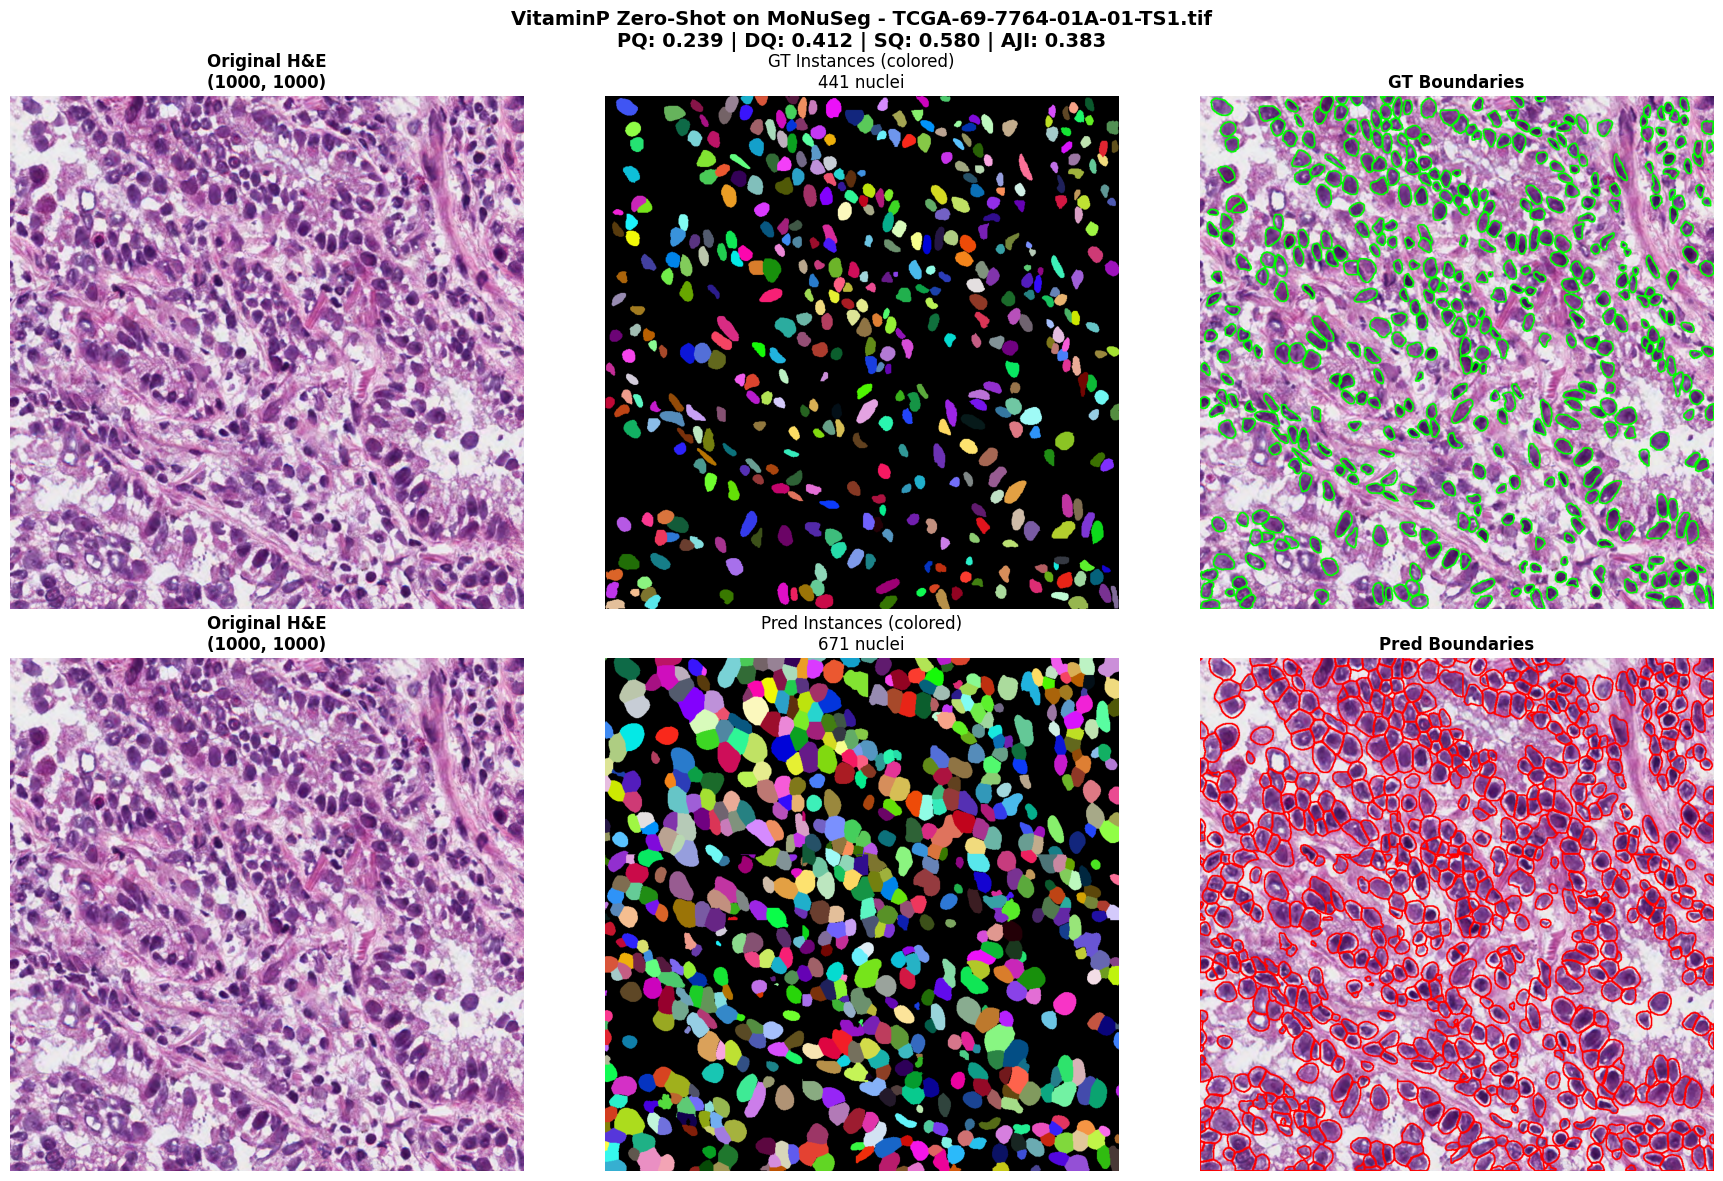


📊 Summary:
  GT: 441 nuclei
  Predicted: 671 nuclei
  Difference: 230 (52.2%)

  Metrics:
  - Panoptic Quality (PQ): 0.2390
  - Detection Quality (DQ): 0.4119
  - Segmentation Quality (SQ): 0.5802
  - Aggregated Jaccard Index (AJI): 0.3830


In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import cv2
from vitaminp import VitaminPBaselineHE
from vitaminp.inference import WSIPredictor
from metrics import get_fast_pq, aggregated_jaccard_index

# Setup model
device = 'cuda'
model = VitaminPBaselineHE(model_size='large', dropout_rate=0.3, freeze_backbone=False)
model.load_state_dict(torch.load("checkpoints/vitamin_p_baselinehe_large_fold3_best.pth", map_location=device))
model = model.to(device)
model.eval()

# Load one sample from MoNuSeg
if len(images) > 0:
    idx = np.random.randint(0, len(images))
    img = images[idx]
    gt_mask = masks[idx]
    filename = filenames[idx]
    
    print(f"🔍 Processing: {filename}")
    print(f"  Image shape: {img.shape}")
    print(f"  GT nuclei: {gt_mask.max()}")
else:
    print("❌ No images loaded! Run the data loading cell first.")
    import sys
    sys.exit()

# Create temp directories
temp_dir = Path("temp_monuseg")
temp_output_dir = Path("temp_monuseg_output")
temp_dir.mkdir(exist_ok=True)
temp_output_dir.mkdir(exist_ok=True)

temp_img_path = temp_dir / filename
Image.fromarray(img.astype(np.uint8)).save(temp_img_path)

# Create predictor
predictor = WSIPredictor(
    model=model,
    device=device,
    patch_size=512,
    overlap=128,
    magnification=40
)

print("\n🔄 Running inference with WSIPredictor...")

# Run inference
results = predictor.predict(
    wsi_path=str(temp_img_path),
    output_dir=str(temp_output_dir),
    branch='he_cell',
    filter_tissue=False,
    clean_overlaps=True,
    save_geojson=False,
    save_json=False,
    save_csv=False,
    save_visualization=False,
    save_masks=False
)

print(f"✅ Detected {results['num_detections']} nuclei in {results['processing_time']:.2f}s")

# Extract instances dictionary
instances_dict = results['instances']

# Create instance map from the dictionary
h, w = img.shape[:2]
nuclei_inst = np.zeros((h, w), dtype=np.int32)

for inst_id, inst_info in instances_dict.items():
    if 'contour' in inst_info:
        contour = np.array(inst_info['contour'], dtype=np.int32)
        cv2.fillPoly(nuclei_inst, [contour], inst_id)
    elif 'coords' in inst_info:
        coords = np.array(inst_info['coords'], dtype=np.int32)
        cv2.fillPoly(nuclei_inst, [coords], inst_id)

num_nuclei = results['num_detections']
num_gt_nuclei = gt_mask.max()

# ========== COMPUTE METRICS ==========
print("\n📊 Computing metrics...")
try:
    pq, dq, sq = get_fast_pq(gt_mask, nuclei_inst)
    aji = aggregated_jaccard_index(gt_mask, nuclei_inst)
    
    print("\n" + "="*60)
    print("🔬 INSTANCE SEGMENTATION METRICS")
    print("="*60)
    print(f"  PQ (Panoptic Quality):     {pq:.4f}")
    print(f"  DQ (Detection Quality):    {dq:.4f}")
    print(f"  SQ (Segmentation Quality): {sq:.4f}")
    print(f"  AJI (Agg. Jaccard Index):  {aji:.4f}")
    print("="*60)
except Exception as e:
    print(f"⚠️ Error computing metrics: {str(e)}")
    pq, dq, sq, aji = 0, 0, 0, 0

# Visualization functions
def colorize_instances(inst_map):
    colored = np.zeros((*inst_map.shape, 3), dtype=np.uint8)
    unique_ids = np.unique(inst_map)
    np.random.seed(42)
    for inst_id in unique_ids:
        if inst_id == 0:
            continue
        colored[inst_map == inst_id] = np.random.randint(0, 255, 3)
    return colored

def draw_instance_boundaries(image, inst_map, color=(0, 255, 0), thickness=1):
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)
    else:
        image = image.astype(np.uint8)
    
    if len(image.shape) == 2:
        output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    else:
        output = image.copy()
    
    unique_ids = np.unique(inst_map)
    for inst_id in unique_ids:
        if inst_id == 0:
            continue
        mask = (inst_map == inst_id).astype(np.uint8)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(output, contours, -1, color, thickness)
    
    return output

# Visualize results
img_viz = img.astype(np.uint8)
gt_colored = colorize_instances(gt_mask)
pred_colored = colorize_instances(nuclei_inst)

gt_boundaries = draw_instance_boundaries(img_viz.copy(), gt_mask, color=(0, 255, 0), thickness=2)
pred_boundaries = draw_instance_boundaries(img_viz.copy(), nuclei_inst, color=(255, 0, 0), thickness=2)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Row 1: Ground Truth
axes[0, 0].imshow(img_viz)
axes[0, 0].set_title(f'Original H&E\n{img.shape[:2]}', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(gt_colored)
axes[0, 1].set_title(f'GT Instances (colored)\n{num_gt_nuclei} nuclei', fontsize=12)
axes[0, 1].axis('off')

axes[0, 2].imshow(gt_boundaries)
axes[0, 2].set_title(f'GT Boundaries', fontsize=12, fontweight='bold')
axes[0, 2].axis('off')

# Row 2: Predictions
axes[1, 0].imshow(img_viz)
axes[1, 0].set_title(f'Original H&E\n{img.shape[:2]}', fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(pred_colored)
axes[1, 1].set_title(f'Pred Instances (colored)\n{num_nuclei} nuclei', fontsize=12)
axes[1, 1].axis('off')

axes[1, 2].imshow(pred_boundaries)
axes[1, 2].set_title(f'Pred Boundaries', fontsize=12, fontweight='bold')
axes[1, 2].axis('off')

# Add metrics as suptitle
plt.suptitle(f'VitaminP Zero-Shot on MoNuSeg - {filename}\n'
             f'PQ: {pq:.3f} | DQ: {dq:.3f} | SQ: {sq:.3f} | AJI: {aji:.3f}', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n📊 Summary:")
print(f"  GT: {num_gt_nuclei} nuclei")
print(f"  Predicted: {num_nuclei} nuclei")
print(f"  Difference: {num_nuclei - num_gt_nuclei} ({((num_nuclei - num_gt_nuclei) / num_gt_nuclei * 100):.1f}%)")
print(f"\n  Metrics:")
print(f"  - Panoptic Quality (PQ): {pq:.4f}")
print(f"  - Detection Quality (DQ): {dq:.4f}")
print(f"  - Segmentation Quality (SQ): {sq:.4f}")
print(f"  - Aggregated Jaccard Index (AJI): {aji:.4f}")

# Cleanup temp files
import shutil
shutil.rmtree(temp_dir)
shutil.rmtree(temp_output_dir)

## Monuseg instance metrics with Baseline

In [16]:
import torch
import numpy as np
from pathlib import Path
from PIL import Image
import cv2
from vitaminp import VitaminPBaselineHE
from vitaminp.inference import WSIPredictor
from metrics import get_fast_pq, aggregated_jaccard_index
from tqdm import tqdm
from collections import defaultdict
import shutil

# Setup model
device = 'cuda'
print("📦 Loading model...")
model = VitaminPBaselineHE(model_size='large', dropout_rate=0.3, freeze_backbone=False)
model.load_state_dict(torch.load("checkpoints/vitamin_p_baselinehe_large_fold3_best.pth", map_location=device))
model = model.to(device)
model.eval()
print("✅ Model loaded")

# Check loaded data
if len(images) == 0:
    print("❌ No images loaded! Run the data loading cell first.")
    import sys
    sys.exit()

print(f"\n🔍 Found {len(images)} images in MoNuSeg test set")

# Create temp directories
temp_dir = Path("temp_monuseg")
temp_output_dir = Path("temp_monuseg_output")
temp_dir.mkdir(exist_ok=True)
temp_output_dir.mkdir(exist_ok=True)

# Initialize metric storage
monuseg_metrics = {
    'pq': [],
    'dq': [],
    'sq': [],
    'aji': [],
    'gt_count': [],
    'pred_count': []
}

# Store per-sample results for detailed analysis
sample_results = []

print(f"\n🔄 Evaluating on MoNuSeg test set ({len(images)} samples)...")
print("="*80)

skipped_samples = 0

for idx in tqdm(range(len(images)), desc="Processing samples"):
    try:
        # Load image and mask
        img = images[idx]
        gt_mask = masks[idx]
        filename = filenames[idx]
        
        # Save temp image for predictor
        temp_img_path = temp_dir / filename
        Image.fromarray(img.astype(np.uint8)).save(temp_img_path)
        
        # Create predictor
        predictor = WSIPredictor(
            model=model,
            device=device,
            patch_size=512,
            overlap=128,
            magnification=40
        )
        
        # Run inference
        results = predictor.predict(
            wsi_path=str(temp_img_path),
            output_dir=str(temp_output_dir),
            branch='he_nuclei',
            filter_tissue=False,
            clean_overlaps=True,
            save_geojson=False,
            save_json=False,
            save_csv=False,
            save_visualization=False,
            save_masks=False
        )
        
        # Extract instances dictionary
        instances_dict = results['instances']
        
        # Create instance map from the dictionary
        h, w = img.shape[:2]
        nuclei_inst = np.zeros((h, w), dtype=np.int32)
        
        for inst_id, inst_info in instances_dict.items():
            if 'contour' in inst_info:
                contour = np.array(inst_info['contour'], dtype=np.int32)
                cv2.fillPoly(nuclei_inst, [contour], inst_id)
            elif 'coords' in inst_info:
                coords = np.array(inst_info['coords'], dtype=np.int32)
                cv2.fillPoly(nuclei_inst, [coords], inst_id)
        
        # Compute metrics
        pq, dq, sq = get_fast_pq(gt_mask, nuclei_inst)
        aji = aggregated_jaccard_index(gt_mask, nuclei_inst)
        
        num_gt = gt_mask.max()
        num_pred = results['num_detections']
        
        # Store metrics
        monuseg_metrics['pq'].append(pq)
        monuseg_metrics['dq'].append(dq)
        monuseg_metrics['sq'].append(sq)
        monuseg_metrics['aji'].append(aji)
        monuseg_metrics['gt_count'].append(num_gt)
        monuseg_metrics['pred_count'].append(num_pred)
        
        # Store detailed sample results
        sample_results.append({
            'filename': filename,
            'pq': pq,
            'dq': dq,
            'sq': sq,
            'aji': aji,
            'gt_count': num_gt,
            'pred_count': num_pred
        })
        
        # Cleanup sample temp files
        temp_img_path.unlink()
        
    except Exception as e:
        print(f"\n⚠️ Skipping sample {idx} ({filenames[idx]}) due to error: {str(e)[:100]}")
        skipped_samples += 1
        continue

# Cleanup temp directories
shutil.rmtree(temp_dir, ignore_errors=True)
shutil.rmtree(temp_output_dir, ignore_errors=True)

# ========== OVERALL RESULTS ==========
print("\n" + "="*80)
print("📊 MONUSEG TEST SET RESULTS - ZERO-SHOT EVALUATION")
print("="*80)

print(f"\nTotal samples processed: {len(monuseg_metrics['pq'])}/{len(images)}")
if skipped_samples > 0:
    print(f"⚠️ Skipped samples: {skipped_samples}")

print("\n🔬 NUCLEI INSTANCE METRICS (all samples):")
print(f"  PQ (Panoptic Quality):     {np.mean(monuseg_metrics['pq']):.4f} ± {np.std(monuseg_metrics['pq']):.4f}")
print(f"  DQ (Detection Quality):    {np.mean(monuseg_metrics['dq']):.4f} ± {np.std(monuseg_metrics['dq']):.4f}")
print(f"  SQ (Segmentation Quality): {np.mean(monuseg_metrics['sq']):.4f} ± {np.std(monuseg_metrics['sq']):.4f}")
print(f"  AJI (Agg. Jaccard Index):  {np.mean(monuseg_metrics['aji']):.4f} ± {np.std(monuseg_metrics['aji']):.4f}")

print("\n📈 DETECTION STATISTICS:")
total_gt = sum(monuseg_metrics['gt_count'])
total_pred = sum(monuseg_metrics['pred_count'])
print(f"  Total GT nuclei:       {total_gt}")
print(f"  Total Pred nuclei:     {total_pred}")
print(f"  Average GT per image:  {np.mean(monuseg_metrics['gt_count']):.1f} ± {np.std(monuseg_metrics['gt_count']):.1f}")
print(f"  Average Pred per image: {np.mean(monuseg_metrics['pred_count']):.1f} ± {np.std(monuseg_metrics['pred_count']):.1f}")
print(f"  Detection ratio:       {total_pred/total_gt:.3f}")

# ========== TOP/BOTTOM PERFORMERS ==========
print("\n" + "="*80)
print("🏆 TOP 5 SAMPLES (by PQ)")
print("="*80)

sorted_by_pq = sorted(sample_results, key=lambda x: x['pq'], reverse=True)
print(f"{'Rank':<6} {'Filename':<40} {'PQ':>8} {'DQ':>8} {'SQ':>8} {'AJI':>8}")
print("-" * 80)
for i, result in enumerate(sorted_by_pq[:5], 1):
    print(f"{i:<6} {result['filename']:<40} {result['pq']:>8.4f} {result['dq']:>8.4f} "
          f"{result['sq']:>8.4f} {result['aji']:>8.4f}")

print("\n" + "="*80)
print("⚠️  BOTTOM 5 SAMPLES (by PQ)")
print("="*80)
print(f"{'Rank':<6} {'Filename':<40} {'PQ':>8} {'DQ':>8} {'SQ':>8} {'AJI':>8}")
print("-" * 80)
for i, result in enumerate(sorted_by_pq[-5:], 1):
    print(f"{i:<6} {result['filename']:<40} {result['pq']:>8.4f} {result['dq']:>8.4f} "
          f"{result['sq']:>8.4f} {result['aji']:>8.4f}")

# ========== PER-SAMPLE DETAILED RESULTS ==========
print("\n" + "="*80)
print("📋 DETAILED PER-SAMPLE RESULTS")
print("="*80)
print(f"{'Filename':<40} {'GT':>6} {'Pred':>6} {'PQ':>8} {'DQ':>8} {'SQ':>8} {'AJI':>8}")
print("-" * 80)
for result in sorted(sample_results, key=lambda x: x['filename']):
    print(f"{result['filename']:<40} {result['gt_count']:>6} {result['pred_count']:>6} "
          f"{result['pq']:>8.4f} {result['dq']:>8.4f} {result['sq']:>8.4f} {result['aji']:>8.4f}")

print("\n" + "="*80)
print("✅ MoNuSeg evaluation complete!")
print("="*80)

📦 Loading model...
Building H&E Baseline encoder with DINOv2-large
✓ VitaminPBaselineHE initialized with large backbone
  Embed dim: 1024 | Decoder dims: [1024, 512, 256, 128]
✅ Model loaded

🔍 Found 14 images in MoNuSeg test set

🔄 Evaluating on MoNuSeg test set (14 samples)...


Processing samples:   0%|          | 0/14 [00:00<?, ?it/s]2026-01-08 18:10:58 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-08 18:10:58 - WSIPredictor - INFO -   Device: cuda
2026-01-08 18:10:58 - WSIPredictor - INFO -   Patch size: 512
2026-01-08 18:10:58 - WSIPredictor - INFO -   Overlap: 128
2026-01-08 18:10:58 - WSIPredictor - INFO -   Magnification: 40
2026-01-08 18:10:58 - WSIPredictor - INFO - 📁 Opening WSI: temp_monuseg/TCGA-2Z-A9J9-01A-01-TS1.tif
2026-01-08 18:10:58 - WSIPredictor - INFO -    ✓ Size: 1000x1000 pixels
2026-01-08 18:10:58 - WSIPredictor - INFO - 📐 Extracting tile positions...
2026-01-08 18:10:58 - WSIPredictor - INFO -    ✓ Created 9 tiles (3x3 grid)
2026-01-08 18:10:58 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on he_nuclei...


⚠️  OpenSlide failed, trying TiffReader
   Scanning 3x3 tile grid...



Processing tiles:   0%|          | 0/9 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  11%|█         | 1/9 [00:00<00:02,  2.73it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  22%|██▏       | 2/9 [00:00<00:02,  2.73it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  33%|███▎      | 3/9 [00:01<00:02,  2.68it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  44%|████▍     | 4/9 [00:01<00:01,  2.76it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  56%|█████▌    | 5/9 [00:01<00:01,  2.76it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  67%|██████▋   | 6/9 [00:02<00:01,  2.74it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  78%|███████▊  | 7/9 [00:02<00:00,  2.85it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  89%|████████▉ | 8/9 [00:02<00:00,  2.83it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 9/9 [00:03<00:00,  2.78it/s]
2026-01-08 18:11:01 - WSIPredictor - INFO -    ✓ Extracted 1652 instances from tiles (before cleaning)
2026-01-08 18:11:01 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-08 18:11:01 - WSIPredictor - INFO -    Found 834 edge cells to check for overlaps
2026-01-08 18:11:01 - WSIPredictor - INFO - Starting overlap cleaning with 1652 detections
2026-01-08 18:11:01 - WSIPredictor - INFO - Split detections: 0 mid, 1652 edge
2026-01-08 18:11:02 - WSIPredictor - INFO - Iteration 1: Found 951 overlaps, keeping 701/1652 detections
2026-01-08 18:11:02 - WSIPredictor - INFO - Iteration 2: Found 17 overlaps, keeping 684/701 detections
2026-01-08 18:11:02 - WSIPredictor - INFO - Iteration 3: Found 2 overlaps, keeping 682/684 detections
2026-01-08 18:11:02 - WSIPredictor - INFO - Iteration 4: Found 0 overlaps, keeping 682/682 detections
2026-01-08 18:11:02 - WSIPredictor - INFO - No more overlaps 

⚠️  OpenSlide failed, trying TiffReader
   Scanning 3x3 tile grid...



Processing tiles:   0%|          | 0/9 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  22%|██▏       | 2/9 [00:00<00:01,  4.05it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  33%|███▎      | 3/9 [00:00<00:01,  4.28it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  44%|████▍     | 4/9 [00:01<00:01,  3.94it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  67%|██████▋   | 6/9 [00:01<00:00,  4.06it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  78%|███████▊  | 7/9 [00:01<00:00,  3.88it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 9/9 [00:02<00:00,  3.98it/s]
2026-01-08 18:11:08 - WSIPredictor - INFO -    ✓ Extracted 2090 instances from tiles (before cleaning)


⚠ GPU requested but CuPy not available, using CPU


2026-01-08 18:11:08 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-08 18:11:08 - WSIPredictor - INFO -    Found 1093 edge cells to check for overlaps
2026-01-08 18:11:08 - WSIPredictor - INFO - Starting overlap cleaning with 2090 detections
2026-01-08 18:11:08 - WSIPredictor - INFO - Split detections: 0 mid, 2090 edge
2026-01-08 18:11:09 - WSIPredictor - INFO - Iteration 1: Found 1209 overlaps, keeping 881/2090 detections
2026-01-08 18:11:09 - WSIPredictor - INFO - Iteration 2: Found 8 overlaps, keeping 873/881 detections
2026-01-08 18:11:09 - WSIPredictor - INFO - Iteration 3: Found 0 overlaps, keeping 873/873 detections
2026-01-08 18:11:09 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-08 18:11:09 - WSIPredictor - INFO - Cleaning complete: 2090 -> 873 (1217 removed)
2026-01-08 18:11:09 - WSIPredictor - INFO -    ✓ After cleaning: 873 instances
2026-01-08 18:11:09 - WSIPredictor - INFO - 💾 Saving results to temp_monuseg_o

⚠️  OpenSlide failed, trying TiffReader
   Scanning 3x3 tile grid...



Processing tiles:   0%|          | 0/9 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  22%|██▏       | 2/9 [00:00<00:01,  4.76it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  33%|███▎      | 3/9 [00:00<00:01,  4.78it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  44%|████▍     | 4/9 [00:00<00:01,  4.96it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  67%|██████▋   | 6/9 [00:01<00:00,  5.30it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  89%|████████▉ | 8/9 [00:01<00:00,  5.40it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 9/9 [00:01<00:00,  5.22it/s]
2026-01-08 18:11:16 - WSIPredictor - INFO -    ✓ Extracted 1412 instances from tiles (before cleaning)
2026-01-08 18:11:16 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-08 18:11:16 - WSIPredictor - INFO -    Found 760 edge cells to check for overlaps
2026-01-08 18:11:16 - WSIPredictor - INFO - Starting overlap cleaning with 1412 detections
2026-01-08 18:11:16 - WSIPredictor - INFO - Split detections: 0 mid, 1412 edge
2026-01-08 18:11:16 - WSIPredictor - INFO - Iteration 1: Found 793 overlaps, keeping 619/1412 detections
2026-01-08 18:11:16 - WSIPredictor - INFO - Iteration 2: Found 15 overlaps, keeping 604/619 detections
2026-01-08 18:11:16 - WSIPredictor - INFO - Iteration 3: Found 0 overlaps, keeping 604/604 detections
2026-01-08 18:11:16 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-08 18:11:16 - WSIPredictor - INFO - Cleaning complete: 1412 -> 604 (808 

⚠️  OpenSlide failed, trying TiffReader
   Scanning 3x3 tile grid...



Processing tiles:   0%|          | 0/9 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  11%|█         | 1/9 [00:00<00:02,  3.32it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  22%|██▏       | 2/9 [00:00<00:02,  3.29it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  33%|███▎      | 3/9 [00:00<00:01,  3.41it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  44%|████▍     | 4/9 [00:01<00:01,  3.33it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  56%|█████▌    | 5/9 [00:01<00:01,  3.22it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  67%|██████▋   | 6/9 [00:02<00:01,  2.60it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  78%|███████▊  | 7/9 [00:02<00:00,  2.86it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 9/9 [00:02<00:00,  3.11it/s]
2026-01-08 18:11:22 - WSIPredictor - INFO -    ✓ Extracted 1324 instances from tiles (before cleaning)
2026-01-08 18:11:22 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-08 18:11:22 - WSIPredictor - INFO -    Found 635 edge cells to check for overlaps


⚠ GPU requested but CuPy not available, using CPU


2026-01-08 18:11:22 - WSIPredictor - INFO - Starting overlap cleaning with 1324 detections
2026-01-08 18:11:22 - WSIPredictor - INFO - Split detections: 0 mid, 1324 edge
2026-01-08 18:11:23 - WSIPredictor - INFO - Iteration 1: Found 776 overlaps, keeping 548/1324 detections
2026-01-08 18:11:23 - WSIPredictor - INFO - Iteration 2: Found 13 overlaps, keeping 535/548 detections
2026-01-08 18:11:23 - WSIPredictor - INFO - Iteration 3: Found 0 overlaps, keeping 535/535 detections
2026-01-08 18:11:23 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-08 18:11:23 - WSIPredictor - INFO - Cleaning complete: 1324 -> 535 (789 removed)
2026-01-08 18:11:23 - WSIPredictor - INFO -    ✓ After cleaning: 535 instances
2026-01-08 18:11:23 - WSIPredictor - INFO - 💾 Saving results to temp_monuseg_output...
2026-01-08 18:11:23 - WSIPredictor - INFO - ✅ Complete! 535 detections in 3.25s
Processing samples:  29%|██▊       | 4/14 [00:28<01:07,  6.71s/it]2026-01-08 18:11:26 - WSIPredictor -

⚠️  OpenSlide failed, trying TiffReader
   Scanning 3x3 tile grid...



Processing tiles:   0%|          | 0/9 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  22%|██▏       | 2/9 [00:00<00:01,  6.20it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  44%|████▍     | 4/9 [00:00<00:00,  5.84it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  56%|█████▌    | 5/9 [00:00<00:00,  5.66it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  78%|███████▊  | 7/9 [00:01<00:00,  5.45it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  89%|████████▉ | 8/9 [00:01<00:00,  5.17it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 9/9 [00:01<00:00,  5.55it/s]
2026-01-08 18:11:27 - WSIPredictor - INFO -    ✓ Extracted 1182 instances from tiles (before cleaning)
2026-01-08 18:11:27 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-08 18:11:27 - WSIPredictor - INFO -    Found 614 edge cells to check for overlaps


⚠ GPU requested but CuPy not available, using CPU


2026-01-08 18:11:28 - WSIPredictor - INFO - Starting overlap cleaning with 1182 detections
2026-01-08 18:11:28 - WSIPredictor - INFO - Split detections: 0 mid, 1182 edge
2026-01-08 18:11:28 - WSIPredictor - INFO - Iteration 1: Found 621 overlaps, keeping 561/1182 detections
2026-01-08 18:11:28 - WSIPredictor - INFO - Iteration 2: Found 6 overlaps, keeping 555/561 detections
2026-01-08 18:11:28 - WSIPredictor - INFO - Iteration 3: Found 0 overlaps, keeping 555/555 detections
2026-01-08 18:11:28 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-08 18:11:28 - WSIPredictor - INFO - Cleaning complete: 1182 -> 555 (627 removed)
2026-01-08 18:11:28 - WSIPredictor - INFO -    ✓ After cleaning: 555 instances
2026-01-08 18:11:28 - WSIPredictor - INFO - 💾 Saving results to temp_monuseg_output...
2026-01-08 18:11:28 - WSIPredictor - INFO - ✅ Complete! 555 detections in 2.07s
Processing samples:  36%|███▌      | 5/14 [00:33<00:56,  6.27s/it]2026-01-08 18:11:31 - WSIPredictor - 

⚠️  OpenSlide failed, trying TiffReader
   Scanning 3x3 tile grid...



Processing tiles:  11%|█         | 1/9 [00:00<00:00,  9.47it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  33%|███▎      | 3/9 [00:00<00:00, 11.02it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  67%|██████▋   | 6/9 [00:00<00:00,  8.85it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 9/9 [00:00<00:00,  9.09it/s]
2026-01-08 18:11:32 - WSIPredictor - INFO -    ✓ Extracted 414 instances from tiles (before cleaning)
2026-01-08 18:11:32 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-08 18:11:32 - WSIPredictor - INFO -    Found 227 edge cells to check for overlaps
2026-01-08 18:11:32 - WSIPredictor - INFO - Starting overlap cleaning with 414 detections


⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU


2026-01-08 18:11:32 - WSIPredictor - INFO - Split detections: 0 mid, 414 edge
2026-01-08 18:11:32 - WSIPredictor - INFO - Iteration 1: Found 153 overlaps, keeping 261/414 detections
2026-01-08 18:11:32 - WSIPredictor - INFO - Iteration 2: Found 3 overlaps, keeping 258/261 detections
2026-01-08 18:11:32 - WSIPredictor - INFO - Iteration 3: Found 0 overlaps, keeping 258/258 detections
2026-01-08 18:11:32 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-08 18:11:32 - WSIPredictor - INFO - Cleaning complete: 414 -> 258 (156 removed)
2026-01-08 18:11:32 - WSIPredictor - INFO -    ✓ After cleaning: 258 instances
2026-01-08 18:11:32 - WSIPredictor - INFO - 💾 Saving results to temp_monuseg_output...
2026-01-08 18:11:32 - WSIPredictor - INFO - ✅ Complete! 258 detections in 1.13s
Processing samples:  43%|████▎     | 6/14 [00:36<00:40,  5.11s/it]2026-01-08 18:11:34 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-08 18:11:34 - WSIPredictor - INFO -   Device: cuda
20

⚠️  OpenSlide failed, trying TiffReader
   Scanning 3x3 tile grid...



Processing tiles:   0%|          | 0/9 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  11%|█         | 1/9 [00:00<00:01,  4.05it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  22%|██▏       | 2/9 [00:00<00:01,  3.94it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  33%|███▎      | 3/9 [00:00<00:01,  3.86it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  44%|████▍     | 4/9 [00:01<00:01,  3.91it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  56%|█████▌    | 5/9 [00:01<00:01,  3.82it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  67%|██████▋   | 6/9 [00:01<00:00,  3.69it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  78%|███████▊  | 7/9 [00:01<00:00,  3.74it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  89%|████████▉ | 8/9 [00:02<00:00,  3.68it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 9/9 [00:02<00:00,  3.75it/s]
2026-01-08 18:11:37 - WSIPredictor - INFO -    ✓ Extracted 2216 instances from tiles (before cleaning)
2026-01-08 18:11:37 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-08 18:11:37 - WSIPredictor - INFO -    Found 1093 edge cells to check for overlaps
2026-01-08 18:11:37 - WSIPredictor - INFO - Starting overlap cleaning with 2216 detections
2026-01-08 18:11:37 - WSIPredictor - INFO - Split detections: 0 mid, 2216 edge
2026-01-08 18:11:37 - WSIPredictor - INFO - Iteration 1: Found 1294 overlaps, keeping 922/2216 detections
2026-01-08 18:11:37 - WSIPredictor - INFO - Iteration 2: Found 29 overlaps, keeping 893/922 detections
2026-01-08 18:11:37 - WSIPredictor - INFO - Iteration 3: Found 1 overlaps, keeping 892/893 detections
2026-01-08 18:11:37 - WSIPredictor - INFO - Iteration 4: Found 0 overlaps, keeping 892/892 detections
2026-01-08 18:11:37 - WSIPredictor - INFO - No more overlap

⚠️  OpenSlide failed, trying TiffReader
   Scanning 3x3 tile grid...



Processing tiles:   0%|          | 0/9 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  22%|██▏       | 2/9 [00:00<00:01,  4.79it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  33%|███▎      | 3/9 [00:00<00:01,  5.29it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  56%|█████▌    | 5/9 [00:00<00:00,  5.08it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  78%|███████▊  | 7/9 [00:01<00:00,  5.20it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  89%|████████▉ | 8/9 [00:01<00:00,  5.49it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 9/9 [00:01<00:00,  5.34it/s]
2026-01-08 18:11:44 - WSIPredictor - INFO -    ✓ Extracted 1293 instances from tiles (before cleaning)
2026-01-08 18:11:44 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-08 18:11:44 - WSIPredictor - INFO -    Found 637 edge cells to check for overlaps
2026-01-08 18:11:44 - WSIPredictor - INFO - Starting overlap cleaning with 1293 detections
2026-01-08 18:11:44 - WSIPredictor - INFO - Split detections: 0 mid, 1293 edge
2026-01-08 18:11:44 - WSIPredictor - INFO - Iteration 1: Found 706 overlaps, keeping 587/1293 detections
2026-01-08 18:11:44 - WSIPredictor - INFO - Iteration 2: Found 12 overlaps, keeping 575/587 detections
2026-01-08 18:11:44 - WSIPredictor - INFO - Iteration 3: Found 0 overlaps, keeping 575/575 detections
2026-01-08 18:11:44 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-08 18:11:44 - WSIPredictor - INFO - Cleaning complete: 1293 -> 575 (718 

⚠️  OpenSlide failed, trying TiffReader
   Scanning 3x3 tile grid...



Processing tiles:  11%|█         | 1/9 [00:00<00:01,  5.53it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  22%|██▏       | 2/9 [00:00<00:01,  5.50it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  33%|███▎      | 3/9 [00:00<00:01,  5.61it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  44%|████▍     | 4/9 [00:00<00:00,  5.49it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  56%|█████▌    | 5/9 [00:00<00:00,  5.44it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  67%|██████▋   | 6/9 [00:01<00:00,  5.38it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  78%|███████▊  | 7/9 [00:01<00:00,  5.34it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  89%|████████▉ | 8/9 [00:01<00:00,  5.32it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 9/9 [00:01<00:00,  5.40it/s]
2026-01-08 18:11:49 - WSIPredictor - INFO -    ✓ Extracted 1214 instances from tiles (before cleaning)
2026-01-08 18:11:49 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-08 18:11:49 - WSIPredictor - INFO -    Found 616 edge cells to check for overlaps
2026-01-08 18:11:49 - WSIPredictor - INFO - Starting overlap cleaning with 1214 detections
2026-01-08 18:11:49 - WSIPredictor - INFO - Split detections: 0 mid, 1214 edge
2026-01-08 18:11:50 - WSIPredictor - INFO - Iteration 1: Found 690 overlaps, keeping 524/1214 detections
2026-01-08 18:11:50 - WSIPredictor - INFO - Iteration 2: Found 12 overlaps, keeping 512/524 detections
2026-01-08 18:11:50 - WSIPredictor - INFO - Iteration 3: Found 0 overlaps, keeping 512/512 detections
2026-01-08 18:11:50 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-08 18:11:50 - WSIPredictor - INFO - Cleaning complete: 1214 -> 512 (702 

⚠️  OpenSlide failed, trying TiffReader
   Scanning 3x3 tile grid...



Processing tiles:  11%|█         | 1/9 [00:00<00:01,  5.84it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  22%|██▏       | 2/9 [00:00<00:01,  6.15it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  33%|███▎      | 3/9 [00:00<00:00,  6.32it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  44%|████▍     | 4/9 [00:00<00:00,  6.58it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  56%|█████▌    | 5/9 [00:00<00:00,  6.68it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  67%|██████▋   | 6/9 [00:00<00:00,  6.64it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  78%|███████▊  | 7/9 [00:01<00:00,  6.81it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  89%|████████▉ | 8/9 [00:01<00:00,  6.92it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 9/9 [00:01<00:00,  6.66it/s]
2026-01-08 18:11:54 - WSIPredictor - INFO -    ✓ Extracted 904 instances from tiles (before cleaning)
2026-01-08 18:11:54 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-08 18:11:54 - WSIPredictor - INFO -    Found 486 edge cells to check for overlaps
2026-01-08 18:11:54 - WSIPredictor - INFO - Starting overlap cleaning with 904 detections
2026-01-08 18:11:54 - WSIPredictor - INFO - Split detections: 0 mid, 904 edge
2026-01-08 18:11:54 - WSIPredictor - INFO - Iteration 1: Found 491 overlaps, keeping 413/904 detections
2026-01-08 18:11:54 - WSIPredictor - INFO - Iteration 2: Found 8 overlaps, keeping 405/413 detections
2026-01-08 18:11:54 - WSIPredictor - INFO - Iteration 3: Found 1 overlaps, keeping 404/405 detections
2026-01-08 18:11:55 - WSIPredictor - INFO - Iteration 4: Found 0 overlaps, keeping 404/404 detections
2026-01-08 18:11:55 - WSIPredictor - INFO - No more overlaps found

⚠️  OpenSlide failed, trying TiffReader
   Scanning 3x3 tile grid...



Processing tiles:  11%|█         | 1/9 [00:00<00:01,  6.16it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  22%|██▏       | 2/9 [00:00<00:01,  6.85it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  33%|███▎      | 3/9 [00:00<00:00,  7.39it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  44%|████▍     | 4/9 [00:00<00:00,  6.60it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  56%|█████▌    | 5/9 [00:00<00:00,  6.36it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  67%|██████▋   | 6/9 [00:00<00:00,  6.51it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  78%|███████▊  | 7/9 [00:01<00:00,  6.16it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  89%|████████▉ | 8/9 [00:01<00:00,  6.30it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 9/9 [00:01<00:00,  6.46it/s]
2026-01-08 18:11:58 - WSIPredictor - INFO -    ✓ Extracted 916 instances from tiles (before cleaning)
2026-01-08 18:11:58 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-08 18:11:58 - WSIPredictor - INFO -    Found 475 edge cells to check for overlaps
2026-01-08 18:11:58 - WSIPredictor - INFO - Starting overlap cleaning with 916 detections
2026-01-08 18:11:58 - WSIPredictor - INFO - Split detections: 0 mid, 916 edge
2026-01-08 18:11:59 - WSIPredictor - INFO - Iteration 1: Found 533 overlaps, keeping 383/916 detections
2026-01-08 18:11:59 - WSIPredictor - INFO - Iteration 2: Found 10 overlaps, keeping 373/383 detections
2026-01-08 18:11:59 - WSIPredictor - INFO - Iteration 3: Found 0 overlaps, keeping 373/373 detections
2026-01-08 18:11:59 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-08 18:11:59 - WSIPredictor - INFO - Cleaning complete: 916 -> 373 (543 remov

⚠️  OpenSlide failed, trying TiffReader
   Scanning 3x3 tile grid...



Processing tiles:  11%|█         | 1/9 [00:00<00:00,  8.02it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  33%|███▎      | 3/9 [00:00<00:00,  8.43it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  44%|████▍     | 4/9 [00:00<00:00,  8.46it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  56%|█████▌    | 5/9 [00:00<00:00,  8.18it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  67%|██████▋   | 6/9 [00:00<00:00,  8.01it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  78%|███████▊  | 7/9 [00:00<00:00,  8.09it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 9/9 [00:01<00:00,  8.44it/s]
2026-01-08 18:12:02 - WSIPredictor - INFO -    ✓ Extracted 528 instances from tiles (before cleaning)
2026-01-08 18:12:02 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-08 18:12:02 - WSIPredictor - INFO -    Found 278 edge cells to check for overlaps


⚠ GPU requested but CuPy not available, using CPU


2026-01-08 18:12:02 - WSIPredictor - INFO - Starting overlap cleaning with 528 detections
2026-01-08 18:12:02 - WSIPredictor - INFO - Split detections: 0 mid, 528 edge
2026-01-08 18:12:02 - WSIPredictor - INFO - Iteration 1: Found 241 overlaps, keeping 287/528 detections
2026-01-08 18:12:02 - WSIPredictor - INFO - Iteration 2: Found 7 overlaps, keeping 280/287 detections
2026-01-08 18:12:02 - WSIPredictor - INFO - Iteration 3: Found 0 overlaps, keeping 280/280 detections
2026-01-08 18:12:02 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-08 18:12:02 - WSIPredictor - INFO - Cleaning complete: 528 -> 280 (248 removed)
2026-01-08 18:12:02 - WSIPredictor - INFO -    ✓ After cleaning: 280 instances
2026-01-08 18:12:02 - WSIPredictor - INFO - 💾 Saving results to temp_monuseg_output...
2026-01-08 18:12:02 - WSIPredictor - INFO - ✅ Complete! 280 detections in 1.40s
Processing samples:  86%|████████▌ | 12/14 [01:06<00:08,  4.31s/it]2026-01-08 18:12:04 - WSIPredictor - INF

⚠️  OpenSlide failed, trying TiffReader
   Scanning 3x3 tile grid...



Processing tiles:   0%|          | 0/9 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  22%|██▏       | 2/9 [00:00<00:01,  4.94it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  44%|████▍     | 4/9 [00:00<00:01,  4.93it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  56%|█████▌    | 5/9 [00:01<00:00,  4.90it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  67%|██████▋   | 6/9 [00:01<00:00,  4.85it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  78%|███████▊  | 7/9 [00:01<00:00,  4.93it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 9/9 [00:01<00:00,  4.99it/s]
2026-01-08 18:12:06 - WSIPredictor - INFO -    ✓ Extracted 1407 instances from tiles (before cleaning)
2026-01-08 18:12:06 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-08 18:12:06 - WSIPredictor - INFO -    Found 734 edge cells to check for overlaps
2026-01-08 18:12:06 - WSIPredictor - INFO - Starting overlap cleaning with 1407 detections
2026-01-08 18:12:06 - WSIPredictor - INFO - Split detections: 0 mid, 1407 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-08 18:12:06 - WSIPredictor - INFO - Iteration 1: Found 798 overlaps, keeping 609/1407 detections
2026-01-08 18:12:06 - WSIPredictor - INFO - Iteration 2: Found 8 overlaps, keeping 601/609 detections
2026-01-08 18:12:06 - WSIPredictor - INFO - Iteration 3: Found 1 overlaps, keeping 600/601 detections
2026-01-08 18:12:06 - WSIPredictor - INFO - Iteration 4: Found 0 overlaps, keeping 600/600 detections
2026-01-08 18:12:06 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-08 18:12:06 - WSIPredictor - INFO - Cleaning complete: 1407 -> 600 (807 removed)
2026-01-08 18:12:06 - WSIPredictor - INFO -    ✓ After cleaning: 600 instances
2026-01-08 18:12:06 - WSIPredictor - INFO - 💾 Saving results to temp_monuseg_output...
2026-01-08 18:12:06 - WSIPredictor - INFO - ✅ Complete! 600 detections in 2.22s
Processing samples:  93%|█████████▎| 13/14 [01:12<00:04,  4.73s/it]2026-01-08 18:12:10 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-08 18:12:10 - WSIPredictor

⚠️  OpenSlide failed, trying TiffReader
   Scanning 3x3 tile grid...



Processing tiles:   0%|          | 0/9 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  11%|█         | 1/9 [00:00<00:01,  5.11it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  33%|███▎      | 3/9 [00:00<00:01,  4.25it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  44%|████▍     | 4/9 [00:00<00:01,  4.83it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  56%|█████▌    | 5/9 [00:01<00:01,  3.85it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  78%|███████▊  | 7/9 [00:01<00:00,  4.28it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 9/9 [00:02<00:00,  4.39it/s]
2026-01-08 18:12:12 - WSIPredictor - INFO -    ✓ Extracted 1453 instances from tiles (before cleaning)
2026-01-08 18:12:12 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-08 18:12:12 - WSIPredictor - INFO -    Found 753 edge cells to check for overlaps
2026-01-08 18:12:12 - WSIPredictor - INFO - Starting overlap cleaning with 1453 detections
2026-01-08 18:12:12 - WSIPredictor - INFO - Split detections: 0 mid, 1453 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-08 18:12:12 - WSIPredictor - INFO - Iteration 1: Found 767 overlaps, keeping 686/1453 detections
2026-01-08 18:12:12 - WSIPredictor - INFO - Iteration 2: Found 12 overlaps, keeping 674/686 detections
2026-01-08 18:12:12 - WSIPredictor - INFO - Iteration 3: Found 1 overlaps, keeping 673/674 detections
2026-01-08 18:12:12 - WSIPredictor - INFO - Iteration 4: Found 0 overlaps, keeping 673/673 detections
2026-01-08 18:12:12 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-08 18:12:12 - WSIPredictor - INFO - Cleaning complete: 1453 -> 673 (780 removed)
2026-01-08 18:12:12 - WSIPredictor - INFO -    ✓ After cleaning: 673 instances
2026-01-08 18:12:12 - WSIPredictor - INFO - 💾 Saving results to temp_monuseg_output...
2026-01-08 18:12:12 - WSIPredictor - INFO - ✅ Complete! 673 detections in 2.55s
Processing samples: 100%|██████████| 14/14 [01:18<00:00,  5.59s/it]


📊 MONUSEG TEST SET RESULTS - ZERO-SHOT EVALUATION

Total samples processed: 14/14

🔬 NUCLEI INSTANCE METRICS (all samples):
  PQ (Panoptic Quality):     0.5834 ± 0.1381
  DQ (Detection Quality):    0.7627 ± 0.1708
  SQ (Segmentation Quality): 0.7606 ± 0.0258
  AJI (Agg. Jaccard Index):  0.5947 ± 0.1464

📈 DETECTION STATISTICS:
  Total GT nuclei:       6697
  Total Pred nuclei:     7816
  Average GT per image:  478.4 ± 141.0
  Average Pred per image: 558.3 ± 183.5
  Detection ratio:       1.167

🏆 TOP 5 SAMPLES (by PQ)
Rank   Filename                                       PQ       DQ       SQ      AJI
--------------------------------------------------------------------------------
1      TCGA-44-2665-01B-06-BS6.tif                0.7021   0.8811   0.7969   0.7017
2      TCGA-IZ-8196-01A-01-BS1.tif                0.7014   0.8914   0.7869   0.7178
3      TCGA-GL-6846-01A-01-BS1.tif                0.6754   0.8643   0.7814   0.6938
4      TCGA-HC-7209-01A-01-TS1.tif                0.6534  

## Felx model

In [17]:
import torch
import numpy as np
from pathlib import Path
from PIL import Image
import cv2
from vitaminp import VitaminPBaselineHE
from vitaminp import VitaminPFlex  # ← Changed from VitaminPBaselineHE
from vitaminp.inference import WSIPredictor
from metrics import get_fast_pq, aggregated_jaccard_index
from tqdm import tqdm
from collections import defaultdict
import shutil

# Setup model
device = 'cuda'
print("📦 Loading model...")
model = VitaminPFlex(model_size='large').to(device)  # ← Changed from VitaminPBaselineHE
model.load_state_dict(torch.load("checkpoints/vitamin_p_flex_large_fold2_best.pth", map_location=device))  # ← Changed checkpoint
model = model.to(device)
model.eval()
print("✅ Model loaded")

# Check loaded data
if len(images) == 0:
    print("❌ No images loaded! Run the data loading cell first.")
    import sys
    sys.exit()

print(f"\n🔍 Found {len(images)} images in MoNuSeg test set")

# Create temp directories
temp_dir = Path("temp_monuseg")
temp_output_dir = Path("temp_monuseg_output")
temp_dir.mkdir(exist_ok=True)
temp_output_dir.mkdir(exist_ok=True)

# Initialize metric storage
monuseg_metrics = {
    'pq': [],
    'dq': [],
    'sq': [],
    'aji': [],
    'gt_count': [],
    'pred_count': []
}

# Store per-sample results for detailed analysis
sample_results = []

print(f"\n🔄 Evaluating on MoNuSeg test set ({len(images)} samples)...")
print("="*80)

skipped_samples = 0

for idx in tqdm(range(len(images)), desc="Processing samples"):
    try:
        # Load image and mask
        img = images[idx]
        gt_mask = masks[idx]
        filename = filenames[idx]
        
        # Save temp image for predictor
        temp_img_path = temp_dir / filename
        Image.fromarray(img.astype(np.uint8)).save(temp_img_path)
        
        # Create predictor
        predictor = WSIPredictor(
            model=model,
            device=device,
            patch_size=512,
            overlap=128,
            magnification=40
        )
        
        # Run inference
        results = predictor.predict(
            wsi_path=str(temp_img_path),
            output_dir=str(temp_output_dir),
            branch='he_nuclei',
            filter_tissue=False,
            clean_overlaps=True,
            save_geojson=False,
            save_json=False,
            save_csv=False,
            save_visualization=False,
            save_masks=False
        )
        
        # Extract instances dictionary
        instances_dict = results['instances']
        
        # Create instance map from the dictionary
        h, w = img.shape[:2]
        nuclei_inst = np.zeros((h, w), dtype=np.int32)
        
        for inst_id, inst_info in instances_dict.items():
            if 'contour' in inst_info:
                contour = np.array(inst_info['contour'], dtype=np.int32)
                cv2.fillPoly(nuclei_inst, [contour], inst_id)
            elif 'coords' in inst_info:
                coords = np.array(inst_info['coords'], dtype=np.int32)
                cv2.fillPoly(nuclei_inst, [coords], inst_id)
        
        # Compute metrics
        pq, dq, sq = get_fast_pq(gt_mask, nuclei_inst)
        aji = aggregated_jaccard_index(gt_mask, nuclei_inst)
        
        num_gt = gt_mask.max()
        num_pred = results['num_detections']
        
        # Store metrics
        monuseg_metrics['pq'].append(pq)
        monuseg_metrics['dq'].append(dq)
        monuseg_metrics['sq'].append(sq)
        monuseg_metrics['aji'].append(aji)
        monuseg_metrics['gt_count'].append(num_gt)
        monuseg_metrics['pred_count'].append(num_pred)
        
        # Store detailed sample results
        sample_results.append({
            'filename': filename,
            'pq': pq,
            'dq': dq,
            'sq': sq,
            'aji': aji,
            'gt_count': num_gt,
            'pred_count': num_pred
        })
        
        # Cleanup sample temp files
        temp_img_path.unlink()
        
    except Exception as e:
        print(f"\n⚠️ Skipping sample {idx} ({filenames[idx]}) due to error: {str(e)[:100]}")
        skipped_samples += 1
        continue

# Cleanup temp directories
shutil.rmtree(temp_dir, ignore_errors=True)
shutil.rmtree(temp_output_dir, ignore_errors=True)

# ========== OVERALL RESULTS ==========
print("\n" + "="*80)
print("📊 MONUSEG TEST SET RESULTS - ZERO-SHOT EVALUATION")
print("="*80)

print(f"\nTotal samples processed: {len(monuseg_metrics['pq'])}/{len(images)}")
if skipped_samples > 0:
    print(f"⚠️ Skipped samples: {skipped_samples}")

print("\n🔬 NUCLEI INSTANCE METRICS (all samples):")
print(f"  PQ (Panoptic Quality):     {np.mean(monuseg_metrics['pq']):.4f} ± {np.std(monuseg_metrics['pq']):.4f}")
print(f"  DQ (Detection Quality):    {np.mean(monuseg_metrics['dq']):.4f} ± {np.std(monuseg_metrics['dq']):.4f}")
print(f"  SQ (Segmentation Quality): {np.mean(monuseg_metrics['sq']):.4f} ± {np.std(monuseg_metrics['sq']):.4f}")
print(f"  AJI (Agg. Jaccard Index):  {np.mean(monuseg_metrics['aji']):.4f} ± {np.std(monuseg_metrics['aji']):.4f}")

print("\n📈 DETECTION STATISTICS:")
total_gt = sum(monuseg_metrics['gt_count'])
total_pred = sum(monuseg_metrics['pred_count'])
print(f"  Total GT nuclei:       {total_gt}")
print(f"  Total Pred nuclei:     {total_pred}")
print(f"  Average GT per image:  {np.mean(monuseg_metrics['gt_count']):.1f} ± {np.std(monuseg_metrics['gt_count']):.1f}")
print(f"  Average Pred per image: {np.mean(monuseg_metrics['pred_count']):.1f} ± {np.std(monuseg_metrics['pred_count']):.1f}")
print(f"  Detection ratio:       {total_pred/total_gt:.3f}")

# ========== TOP/BOTTOM PERFORMERS ==========
print("\n" + "="*80)
print("🏆 TOP 5 SAMPLES (by PQ)")
print("="*80)

sorted_by_pq = sorted(sample_results, key=lambda x: x['pq'], reverse=True)
print(f"{'Rank':<6} {'Filename':<40} {'PQ':>8} {'DQ':>8} {'SQ':>8} {'AJI':>8}")
print("-" * 80)
for i, result in enumerate(sorted_by_pq[:5], 1):
    print(f"{i:<6} {result['filename']:<40} {result['pq']:>8.4f} {result['dq']:>8.4f} "
          f"{result['sq']:>8.4f} {result['aji']:>8.4f}")

print("\n" + "="*80)
print("⚠️  BOTTOM 5 SAMPLES (by PQ)")
print("="*80)
print(f"{'Rank':<6} {'Filename':<40} {'PQ':>8} {'DQ':>8} {'SQ':>8} {'AJI':>8}")
print("-" * 80)
for i, result in enumerate(sorted_by_pq[-5:], 1):
    print(f"{i:<6} {result['filename']:<40} {result['pq']:>8.4f} {result['dq']:>8.4f} "
          f"{result['sq']:>8.4f} {result['aji']:>8.4f}")

# ========== PER-SAMPLE DETAILED RESULTS ==========
print("\n" + "="*80)
print("📋 DETAILED PER-SAMPLE RESULTS")
print("="*80)
print(f"{'Filename':<40} {'GT':>6} {'Pred':>6} {'PQ':>8} {'DQ':>8} {'SQ':>8} {'AJI':>8}")
print("-" * 80)
for result in sorted(sample_results, key=lambda x: x['filename']):
    print(f"{result['filename']:<40} {result['gt_count']:>6} {result['pred_count']:>6} "
          f"{result['pq']:>8.4f} {result['dq']:>8.4f} {result['sq']:>8.4f} {result['aji']:>8.4f}")

print("\n" + "="*80)
print("✅ MoNuSeg evaluation complete!")
print("="*80)

📦 Loading model...
✓ VitaminPFlex initialized with large backbone
  Architecture: Shared Encoder → 4 Separate Decoders
  Embed dim: 1024 | Decoder dims: [1024, 512, 256, 128]
✅ Model loaded

🔍 Found 14 images in MoNuSeg test set

🔄 Evaluating on MoNuSeg test set (14 samples)...


Processing samples:   0%|          | 0/14 [00:00<?, ?it/s]2026-01-08 18:14:31 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-08 18:14:31 - WSIPredictor - INFO -   Device: cuda
2026-01-08 18:14:31 - WSIPredictor - INFO -   Patch size: 512
2026-01-08 18:14:31 - WSIPredictor - INFO -   Overlap: 128
2026-01-08 18:14:31 - WSIPredictor - INFO -   Magnification: 40
2026-01-08 18:14:31 - WSIPredictor - INFO - 📁 Opening WSI: temp_monuseg/TCGA-2Z-A9J9-01A-01-TS1.tif
2026-01-08 18:14:31 - WSIPredictor - INFO -    ✓ Size: 1000x1000 pixels
2026-01-08 18:14:31 - WSIPredictor - INFO - 📐 Extracting tile positions...
2026-01-08 18:14:31 - WSIPredictor - INFO -    ✓ Created 9 tiles (3x3 grid)
2026-01-08 18:14:31 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on he_nuclei...


⚠️  OpenSlide failed, trying TiffReader
   Scanning 3x3 tile grid...



Processing tiles:   0%|          | 0/9 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  11%|█         | 1/9 [00:00<00:02,  2.89it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  22%|██▏       | 2/9 [00:00<00:02,  2.85it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  33%|███▎      | 3/9 [00:01<00:02,  2.81it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  44%|████▍     | 4/9 [00:01<00:01,  2.88it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  56%|█████▌    | 5/9 [00:01<00:01,  2.87it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  78%|███████▊  | 7/9 [00:02<00:00,  2.85it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  89%|████████▉ | 8/9 [00:02<00:00,  3.26it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 9/9 [00:02<00:00,  3.06it/s]
2026-01-08 18:14:34 - WSIPredictor - INFO -    ✓ Extracted 1550 instances from tiles (before cleaning)
2026-01-08 18:14:34 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-08 18:14:34 - WSIPredictor - INFO -    Found 774 edge cells to check for overlaps
2026-01-08 18:14:34 - WSIPredictor - INFO - Starting overlap cleaning with 1550 detections
2026-01-08 18:14:34 - WSIPredictor - INFO - Split detections: 0 mid, 1550 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-08 18:14:34 - WSIPredictor - INFO - Iteration 1: Found 885 overlaps, keeping 665/1550 detections
2026-01-08 18:14:34 - WSIPredictor - INFO - Iteration 2: Found 13 overlaps, keeping 652/665 detections
2026-01-08 18:14:34 - WSIPredictor - INFO - Iteration 3: Found 1 overlaps, keeping 651/652 detections
2026-01-08 18:14:34 - WSIPredictor - INFO - Iteration 4: Found 0 overlaps, keeping 651/651 detections
2026-01-08 18:14:34 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-08 18:14:34 - WSIPredictor - INFO - Cleaning complete: 1550 -> 651 (899 removed)
2026-01-08 18:14:34 - WSIPredictor - INFO -    ✓ After cleaning: 651 instances
2026-01-08 18:14:34 - WSIPredictor - INFO - 💾 Saving results to temp_monuseg_output...
2026-01-08 18:14:34 - WSIPredictor - INFO - ✅ Complete! 651 detections in 3.45s
Processing samples:   7%|▋         | 1/14 [00:08<01:56,  8.97s/it]2026-01-08 18:14:40 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-08 18:14:40 - WSIPredictor

⚠️  OpenSlide failed, trying TiffReader
   Scanning 3x3 tile grid...



Processing tiles:   0%|          | 0/9 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  22%|██▏       | 2/9 [00:00<00:01,  4.10it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  33%|███▎      | 3/9 [00:00<00:01,  4.34it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  56%|█████▌    | 5/9 [00:01<00:00,  4.04it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  67%|██████▋   | 6/9 [00:01<00:00,  4.19it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  78%|███████▊  | 7/9 [00:01<00:00,  3.41it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 9/9 [00:02<00:00,  3.83it/s]
2026-01-08 18:14:42 - WSIPredictor - INFO -    ✓ Extracted 2061 instances from tiles (before cleaning)


⚠ GPU requested but CuPy not available, using CPU


2026-01-08 18:14:42 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-08 18:14:42 - WSIPredictor - INFO -    Found 1079 edge cells to check for overlaps
2026-01-08 18:14:42 - WSIPredictor - INFO - Starting overlap cleaning with 2061 detections
2026-01-08 18:14:42 - WSIPredictor - INFO - Split detections: 0 mid, 2061 edge
2026-01-08 18:14:43 - WSIPredictor - INFO - Iteration 1: Found 1190 overlaps, keeping 871/2061 detections
2026-01-08 18:14:43 - WSIPredictor - INFO - Iteration 2: Found 6 overlaps, keeping 865/871 detections
2026-01-08 18:14:43 - WSIPredictor - INFO - Iteration 3: Found 0 overlaps, keeping 865/865 detections
2026-01-08 18:14:43 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-08 18:14:43 - WSIPredictor - INFO - Cleaning complete: 2061 -> 865 (1196 removed)
2026-01-08 18:14:43 - WSIPredictor - INFO -    ✓ After cleaning: 865 instances
2026-01-08 18:14:43 - WSIPredictor - INFO - 💾 Saving results to temp_monuseg_o

⚠️  OpenSlide failed, trying TiffReader
   Scanning 3x3 tile grid...



Processing tiles:   0%|          | 0/9 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  22%|██▏       | 2/9 [00:00<00:01,  4.74it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  33%|███▎      | 3/9 [00:00<00:01,  4.69it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  44%|████▍     | 4/9 [00:00<00:01,  4.83it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  56%|█████▌    | 5/9 [00:01<00:00,  4.18it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  67%|██████▋   | 6/9 [00:01<00:00,  3.96it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  78%|███████▊  | 7/9 [00:01<00:00,  3.82it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  89%|████████▉ | 8/9 [00:02<00:00,  3.05it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 9/9 [00:02<00:00,  3.69it/s]
2026-01-08 18:14:51 - WSIPredictor - INFO -    ✓ Extracted 1283 instances from tiles (before cleaning)
2026-01-08 18:14:51 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-08 18:14:51 - WSIPredictor - INFO -    Found 701 edge cells to check for overlaps
2026-01-08 18:14:51 - WSIPredictor - INFO - Starting overlap cleaning with 1283 detections
2026-01-08 18:14:51 - WSIPredictor - INFO - Split detections: 0 mid, 1283 edge
2026-01-08 18:14:51 - WSIPredictor - INFO - Iteration 1: Found 715 overlaps, keeping 568/1283 detections
2026-01-08 18:14:51 - WSIPredictor - INFO - Iteration 2: Found 9 overlaps, keeping 559/568 detections
2026-01-08 18:14:51 - WSIPredictor - INFO - Iteration 3: Found 0 overlaps, keeping 559/559 detections
2026-01-08 18:14:51 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-08 18:14:51 - WSIPredictor - INFO - Cleaning complete: 1283 -> 559 (724 r

⚠️  OpenSlide failed, trying TiffReader
   Scanning 3x3 tile grid...



Processing tiles:  11%|█         | 1/9 [00:00<00:01,  5.91it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  22%|██▏       | 2/9 [00:00<00:01,  5.71it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  33%|███▎      | 3/9 [00:00<00:01,  5.86it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  44%|████▍     | 4/9 [00:00<00:00,  5.79it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  56%|█████▌    | 5/9 [00:00<00:00,  5.70it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  67%|██████▋   | 6/9 [00:01<00:00,  5.77it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  78%|███████▊  | 7/9 [00:01<00:00,  6.00it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  89%|████████▉ | 8/9 [00:01<00:00,  5.93it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 9/9 [00:01<00:00,  5.85it/s]
2026-01-08 18:14:56 - WSIPredictor - INFO -    ✓ Extracted 1177 instances from tiles (before cleaning)
2026-01-08 18:14:56 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-08 18:14:56 - WSIPredictor - INFO -    Found 561 edge cells to check for overlaps
2026-01-08 18:14:56 - WSIPredictor - INFO - Starting overlap cleaning with 1177 detections
2026-01-08 18:14:56 - WSIPredictor - INFO - Split detections: 0 mid, 1177 edge
2026-01-08 18:14:56 - WSIPredictor - INFO - Iteration 1: Found 690 overlaps, keeping 487/1177 detections
2026-01-08 18:14:56 - WSIPredictor - INFO - Iteration 2: Found 7 overlaps, keeping 480/487 detections
2026-01-08 18:14:56 - WSIPredictor - INFO - Iteration 3: Found 0 overlaps, keeping 480/480 detections
2026-01-08 18:14:56 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-08 18:14:56 - WSIPredictor - INFO - Cleaning complete: 1177 -> 480 (697 r

⚠️  OpenSlide failed, trying TiffReader
   Scanning 3x3 tile grid...



Processing tiles:  11%|█         | 1/9 [00:00<00:01,  5.94it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  33%|███▎      | 3/9 [00:00<00:00,  7.96it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  44%|████▍     | 4/9 [00:00<00:00,  6.71it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  56%|█████▌    | 5/9 [00:00<00:00,  6.56it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  67%|██████▋   | 6/9 [00:00<00:00,  6.73it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  78%|███████▊  | 7/9 [00:01<00:00,  6.09it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  89%|████████▉ | 8/9 [00:01<00:00,  6.06it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 9/9 [00:01<00:00,  6.36it/s]
2026-01-08 18:15:01 - WSIPredictor - INFO -    ✓ Extracted 908 instances from tiles (before cleaning)
2026-01-08 18:15:01 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-08 18:15:01 - WSIPredictor - INFO -    Found 450 edge cells to check for overlaps
2026-01-08 18:15:01 - WSIPredictor - INFO - Starting overlap cleaning with 908 detections
2026-01-08 18:15:01 - WSIPredictor - INFO - Split detections: 0 mid, 908 edge
2026-01-08 18:15:01 - WSIPredictor - INFO - Iteration 1: Found 482 overlaps, keeping 426/908 detections
2026-01-08 18:15:01 - WSIPredictor - INFO - Iteration 2: Found 3 overlaps, keeping 423/426 detections
2026-01-08 18:15:01 - WSIPredictor - INFO - Iteration 3: Found 0 overlaps, keeping 423/423 detections
2026-01-08 18:15:01 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-08 18:15:01 - WSIPredictor - INFO - Cleaning complete: 908 -> 423 (485 remove

⚠️  OpenSlide failed, trying TiffReader
   Scanning 3x3 tile grid...



Processing tiles:  11%|█         | 1/9 [00:00<00:00,  8.73it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  33%|███▎      | 3/9 [00:00<00:00,  8.47it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  67%|██████▋   | 6/9 [00:00<00:00,  9.54it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  78%|███████▊  | 7/9 [00:00<00:00,  9.50it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 9/9 [00:00<00:00,  9.65it/s]
2026-01-08 18:15:05 - WSIPredictor - INFO -    ✓ Extracted 349 instances from tiles (before cleaning)
2026-01-08 18:15:05 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-08 18:15:05 - WSIPredictor - INFO -    Found 178 edge cells to check for overlaps
2026-01-08 18:15:05 - WSIPredictor - INFO - Starting overlap cleaning with 349 detections
2026-01-08 18:15:05 - WSIPredictor - INFO - Split detections: 0 mid, 349 edge
2026-01-08 18:15:05 - WSIPredictor - INFO - Iteration 1: Found 116 overlaps, keeping 233/349 detections
2026-01-08 18:15:05 - WSIPredictor - INFO - Iteration 2: Found 5 overlaps, keeping 228/233 detections
2026-01-08 18:15:05 - WSIPredictor - INFO - Iteration 3: Found 1 overlaps, keeping 227/228 detections
2026-01-08 18:15:05 - WSIPredictor - INFO - Iteration 4: Found 0 overlaps, keeping 227/227 detections
2026-01-08 18:15:05 - WSIPredictor - INFO - No more overlaps found

⚠️  OpenSlide failed, trying TiffReader
   Scanning 3x3 tile grid...



Processing tiles:   0%|          | 0/9 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  11%|█         | 1/9 [00:00<00:01,  5.25it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  22%|██▏       | 2/9 [00:00<00:01,  5.21it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  44%|████▍     | 4/9 [00:00<00:00,  5.10it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  56%|█████▌    | 5/9 [00:01<00:00,  4.77it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  78%|███████▊  | 7/9 [00:01<00:00,  4.60it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  89%|████████▉ | 8/9 [00:01<00:00,  4.41it/s]


⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 9/9 [00:01<00:00,  4.59it/s]
2026-01-08 18:15:09 - WSIPredictor - INFO -    ✓ Extracted 1703 instances from tiles (before cleaning)
2026-01-08 18:15:09 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-08 18:15:09 - WSIPredictor - INFO -    Found 823 edge cells to check for overlaps
2026-01-08 18:15:09 - WSIPredictor - INFO - Starting overlap cleaning with 1703 detections
2026-01-08 18:15:09 - WSIPredictor - INFO - Split detections: 0 mid, 1703 edge
2026-01-08 18:15:09 - WSIPredictor - INFO - Iteration 1: Found 1005 overlaps, keeping 698/1703 detections
2026-01-08 18:15:09 - WSIPredictor - INFO - Iteration 2: Found 8 overlaps, keeping 690/698 detections
2026-01-08 18:15:09 - WSIPredictor - INFO - Iteration 3: Found 0 overlaps, keeping 690/690 detections
2026-01-08 18:15:09 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-08 18:15:09 - WSIPredictor - INFO - Cleaning complete: 1703 -> 690 (1013 

⚠️  OpenSlide failed, trying TiffReader
   Scanning 3x3 tile grid...



Processing tiles:   0%|          | 0/9 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  11%|█         | 1/9 [00:00<00:01,  5.28it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  22%|██▏       | 2/9 [00:00<00:01,  5.36it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  33%|███▎      | 3/9 [00:00<00:01,  5.78it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  56%|█████▌    | 5/9 [00:00<00:00,  5.72it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  78%|███████▊  | 7/9 [00:01<00:00,  5.75it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 9/9 [00:01<00:00,  5.91it/s]
2026-01-08 18:15:15 - WSIPredictor - INFO -    ✓ Extracted 1055 instances from tiles (before cleaning)
2026-01-08 18:15:15 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-08 18:15:15 - WSIPredictor - INFO -    Found 516 edge cells to check for overlaps
2026-01-08 18:15:15 - WSIPredictor - INFO - Starting overlap cleaning with 1055 detections
2026-01-08 18:15:15 - WSIPredictor - INFO - Split detections: 0 mid, 1055 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-08 18:15:15 - WSIPredictor - INFO - Iteration 1: Found 589 overlaps, keeping 466/1055 detections
2026-01-08 18:15:15 - WSIPredictor - INFO - Iteration 2: Found 6 overlaps, keeping 460/466 detections
2026-01-08 18:15:15 - WSIPredictor - INFO - Iteration 3: Found 0 overlaps, keeping 460/460 detections
2026-01-08 18:15:15 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-08 18:15:15 - WSIPredictor - INFO - Cleaning complete: 1055 -> 460 (595 removed)
2026-01-08 18:15:15 - WSIPredictor - INFO -    ✓ After cleaning: 460 instances
2026-01-08 18:15:15 - WSIPredictor - INFO - 💾 Saving results to temp_monuseg_output...
2026-01-08 18:15:15 - WSIPredictor - INFO - ✅ Complete! 460 detections in 1.80s
Processing samples:  57%|█████▋    | 8/14 [00:46<00:30,  5.14s/it]2026-01-08 18:15:18 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-08 18:15:18 - WSIPredictor - INFO -   Device: cuda
2026-01-08 18:15:18 - WSIPredictor - INFO -   Patch size: 512
2026-01-08 18:15

⚠️  OpenSlide failed, trying TiffReader
   Scanning 3x3 tile grid...



Processing tiles:  11%|█         | 1/9 [00:00<00:01,  5.42it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  22%|██▏       | 2/9 [00:00<00:01,  5.40it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  33%|███▎      | 3/9 [00:00<00:01,  5.39it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  56%|█████▌    | 5/9 [00:01<00:00,  4.69it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  78%|███████▊  | 7/9 [00:01<00:00,  5.16it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 9/9 [00:01<00:00,  5.13it/s]
2026-01-08 18:15:20 - WSIPredictor - INFO -    ✓ Extracted 1130 instances from tiles (before cleaning)
2026-01-08 18:15:20 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-08 18:15:20 - WSIPredictor - INFO -    Found 594 edge cells to check for overlaps
2026-01-08 18:15:20 - WSIPredictor - INFO - Starting overlap cleaning with 1130 detections
2026-01-08 18:15:20 - WSIPredictor - INFO - Split detections: 0 mid, 1130 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-08 18:15:20 - WSIPredictor - INFO - Iteration 1: Found 634 overlaps, keeping 496/1130 detections
2026-01-08 18:15:20 - WSIPredictor - INFO - Iteration 2: Found 10 overlaps, keeping 486/496 detections
2026-01-08 18:15:20 - WSIPredictor - INFO - Iteration 3: Found 0 overlaps, keeping 486/486 detections
2026-01-08 18:15:20 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-08 18:15:20 - WSIPredictor - INFO - Cleaning complete: 1130 -> 486 (644 removed)
2026-01-08 18:15:20 - WSIPredictor - INFO -    ✓ After cleaning: 486 instances
2026-01-08 18:15:20 - WSIPredictor - INFO - 💾 Saving results to temp_monuseg_output...
2026-01-08 18:15:20 - WSIPredictor - INFO - ✅ Complete! 486 detections in 2.07s
Processing samples:  64%|██████▍   | 9/14 [00:51<00:25,  5.08s/it]2026-01-08 18:15:23 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-08 18:15:23 - WSIPredictor - INFO -   Device: cuda
2026-01-08 18:15:23 - WSIPredictor - INFO -   Patch size: 512
2026-01-08 18:1

⚠️  OpenSlide failed, trying TiffReader
   Scanning 3x3 tile grid...



Processing tiles:  11%|█         | 1/9 [00:00<00:01,  6.19it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  22%|██▏       | 2/9 [00:00<00:01,  6.34it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  33%|███▎      | 3/9 [00:00<00:00,  6.43it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  44%|████▍     | 4/9 [00:00<00:00,  6.70it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  56%|█████▌    | 5/9 [00:00<00:00,  6.78it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  67%|██████▋   | 6/9 [00:00<00:00,  6.67it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  78%|███████▊  | 7/9 [00:01<00:00,  6.75it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  89%|████████▉ | 8/9 [00:01<00:00,  6.83it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 9/9 [00:01<00:00,  6.69it/s]
2026-01-08 18:15:24 - WSIPredictor - INFO -    ✓ Extracted 865 instances from tiles (before cleaning)
2026-01-08 18:15:24 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-08 18:15:24 - WSIPredictor - INFO -    Found 471 edge cells to check for overlaps
2026-01-08 18:15:24 - WSIPredictor - INFO - Starting overlap cleaning with 865 detections
2026-01-08 18:15:24 - WSIPredictor - INFO - Split detections: 0 mid, 865 edge
2026-01-08 18:15:24 - WSIPredictor - INFO - Iteration 1: Found 476 overlaps, keeping 389/865 detections
2026-01-08 18:15:25 - WSIPredictor - INFO - Iteration 2: Found 3 overlaps, keeping 386/389 detections
2026-01-08 18:15:25 - WSIPredictor - INFO - Iteration 3: Found 0 overlaps, keeping 386/386 detections
2026-01-08 18:15:25 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-08 18:15:25 - WSIPredictor - INFO - Cleaning complete: 865 -> 386 (479 remove

⚠️  OpenSlide failed, trying TiffReader
   Scanning 3x3 tile grid...



Processing tiles:  11%|█         | 1/9 [00:00<00:01,  6.75it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  22%|██▏       | 2/9 [00:00<00:00,  7.45it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  33%|███▎      | 3/9 [00:00<00:00,  7.86it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  44%|████▍     | 4/9 [00:00<00:00,  7.06it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  56%|█████▌    | 5/9 [00:00<00:00,  6.91it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  67%|██████▋   | 6/9 [00:00<00:00,  7.02it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  78%|███████▊  | 7/9 [00:01<00:00,  6.52it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  89%|████████▉ | 8/9 [00:01<00:00,  6.53it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 9/9 [00:01<00:00,  6.84it/s]
2026-01-08 18:15:28 - WSIPredictor - INFO -    ✓ Extracted 792 instances from tiles (before cleaning)
2026-01-08 18:15:28 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-08 18:15:28 - WSIPredictor - INFO -    Found 418 edge cells to check for overlaps
2026-01-08 18:15:28 - WSIPredictor - INFO - Starting overlap cleaning with 792 detections
2026-01-08 18:15:28 - WSIPredictor - INFO - Split detections: 0 mid, 792 edge
2026-01-08 18:15:28 - WSIPredictor - INFO - Iteration 1: Found 451 overlaps, keeping 341/792 detections
2026-01-08 18:15:28 - WSIPredictor - INFO - Iteration 2: Found 6 overlaps, keeping 335/341 detections
2026-01-08 18:15:28 - WSIPredictor - INFO - Iteration 3: Found 0 overlaps, keeping 335/335 detections
2026-01-08 18:15:28 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-08 18:15:28 - WSIPredictor - INFO - Cleaning complete: 792 -> 335 (457 remove

⚠️  OpenSlide failed, trying TiffReader
   Scanning 3x3 tile grid...



Processing tiles:  11%|█         | 1/9 [00:00<00:00,  8.10it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  33%|███▎      | 3/9 [00:00<00:00,  8.17it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  56%|█████▌    | 5/9 [00:00<00:00,  7.95it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  78%|███████▊  | 7/9 [00:00<00:00,  8.04it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 9/9 [00:01<00:00,  7.92it/s]
2026-01-08 18:15:32 - WSIPredictor - INFO -    ✓ Extracted 590 instances from tiles (before cleaning)
2026-01-08 18:15:32 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-08 18:15:32 - WSIPredictor - INFO -    Found 313 edge cells to check for overlaps
2026-01-08 18:15:32 - WSIPredictor - INFO - Starting overlap cleaning with 590 detections
2026-01-08 18:15:32 - WSIPredictor - INFO - Split detections: 0 mid, 590 edge
2026-01-08 18:15:32 - WSIPredictor - INFO - Iteration 1: Found 331 overlaps, keeping 259/590 detections


⚠ GPU requested but CuPy not available, using CPU


2026-01-08 18:15:32 - WSIPredictor - INFO - Iteration 2: Found 10 overlaps, keeping 249/259 detections
2026-01-08 18:15:32 - WSIPredictor - INFO - Iteration 3: Found 0 overlaps, keeping 249/249 detections
2026-01-08 18:15:32 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-08 18:15:32 - WSIPredictor - INFO - Cleaning complete: 590 -> 249 (341 removed)
2026-01-08 18:15:32 - WSIPredictor - INFO -    ✓ After cleaning: 249 instances
2026-01-08 18:15:32 - WSIPredictor - INFO - 💾 Saving results to temp_monuseg_output...
2026-01-08 18:15:32 - WSIPredictor - INFO - ✅ Complete! 249 detections in 1.30s
Processing samples:  86%|████████▌ | 12/14 [01:02<00:07,  3.97s/it]2026-01-08 18:15:33 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-08 18:15:33 - WSIPredictor - INFO -   Device: cuda
2026-01-08 18:15:33 - WSIPredictor - INFO -   Patch size: 512
2026-01-08 18:15:33 - WSIPredictor - INFO -   Overlap: 128
2026-01-08 18:15:33 - WSIPredictor - INFO -   Magnification: 

⚠️  OpenSlide failed, trying TiffReader
   Scanning 3x3 tile grid...



Processing tiles:   0%|          | 0/9 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  11%|█         | 1/9 [00:00<00:01,  5.09it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  22%|██▏       | 2/9 [00:00<00:01,  5.19it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  33%|███▎      | 3/9 [00:00<00:01,  5.20it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  44%|████▍     | 4/9 [00:00<00:00,  5.16it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  67%|██████▋   | 6/9 [00:01<00:00,  5.18it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  78%|███████▊  | 7/9 [00:01<00:00,  5.24it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 9/9 [00:01<00:00,  4.81it/s]
2026-01-08 18:15:35 - WSIPredictor - INFO -    ✓ Extracted 1328 instances from tiles (before cleaning)
2026-01-08 18:15:35 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-08 18:15:35 - WSIPredictor - INFO -    Found 702 edge cells to check for overlaps
2026-01-08 18:15:35 - WSIPredictor - INFO - Starting overlap cleaning with 1328 detections
2026-01-08 18:15:35 - WSIPredictor - INFO - Split detections: 0 mid, 1328 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-08 18:15:36 - WSIPredictor - INFO - Iteration 1: Found 770 overlaps, keeping 558/1328 detections
2026-01-08 18:15:36 - WSIPredictor - INFO - Iteration 2: Found 6 overlaps, keeping 552/558 detections
2026-01-08 18:15:36 - WSIPredictor - INFO - Iteration 3: Found 0 overlaps, keeping 552/552 detections
2026-01-08 18:15:36 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-08 18:15:36 - WSIPredictor - INFO - Cleaning complete: 1328 -> 552 (776 removed)
2026-01-08 18:15:36 - WSIPredictor - INFO -    ✓ After cleaning: 552 instances
2026-01-08 18:15:36 - WSIPredictor - INFO - 💾 Saving results to temp_monuseg_output...
2026-01-08 18:15:36 - WSIPredictor - INFO - ✅ Complete! 552 detections in 2.21s
Processing samples:  93%|█████████▎| 13/14 [01:07<00:04,  4.40s/it]2026-01-08 18:15:39 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-08 18:15:39 - WSIPredictor - INFO -   Device: cuda
2026-01-08 18:15:39 - WSIPredictor - INFO -   Patch size: 512
2026-01-08 18:1

⚠️  OpenSlide failed, trying TiffReader
   Scanning 3x3 tile grid...



Processing tiles:  11%|█         | 1/9 [00:00<00:01,  5.82it/s]

⚠ GPU requested but CuPy not available, using CPU
⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  22%|██▏       | 2/9 [00:00<00:01,  6.08it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  33%|███▎      | 3/9 [00:00<00:00,  6.22it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  44%|████▍     | 4/9 [00:00<00:00,  6.12it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  56%|█████▌    | 5/9 [00:00<00:00,  6.20it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  67%|██████▋   | 6/9 [00:00<00:00,  6.09it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  78%|███████▊  | 7/9 [00:01<00:00,  5.90it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles:  89%|████████▉ | 8/9 [00:01<00:00,  5.89it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 9/9 [00:01<00:00,  5.95it/s]
2026-01-08 18:15:40 - WSIPredictor - INFO -    ✓ Extracted 1044 instances from tiles (before cleaning)
2026-01-08 18:15:40 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-08 18:15:40 - WSIPredictor - INFO -    Found 528 edge cells to check for overlaps
2026-01-08 18:15:41 - WSIPredictor - INFO - Starting overlap cleaning with 1044 detections
2026-01-08 18:15:41 - WSIPredictor - INFO - Split detections: 0 mid, 1044 edge
2026-01-08 18:15:41 - WSIPredictor - INFO - Iteration 1: Found 582 overlaps, keeping 462/1044 detections
2026-01-08 18:15:41 - WSIPredictor - INFO - Iteration 2: Found 1 overlaps, keeping 461/462 detections
2026-01-08 18:15:41 - WSIPredictor - INFO - Iteration 3: Found 0 overlaps, keeping 461/461 detections
2026-01-08 18:15:41 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-08 18:15:41 - WSIPredictor - INFO - Cleaning complete: 1044 -> 461 (583 r


📊 MONUSEG TEST SET RESULTS - ZERO-SHOT EVALUATION

Total samples processed: 14/14

🔬 NUCLEI INSTANCE METRICS (all samples):
  PQ (Panoptic Quality):     0.6222 ± 0.1272
  DQ (Detection Quality):    0.8051 ± 0.1490
  SQ (Segmentation Quality): 0.7687 ± 0.0296
  AJI (Agg. Jaccard Index):  0.6330 ± 0.1428

📈 DETECTION STATISTICS:
  Total GT nuclei:       6697
  Total Pred nuclei:     6824
  Average GT per image:  478.4 ± 141.0
  Average Pred per image: 487.4 ± 165.5
  Detection ratio:       1.019

🏆 TOP 5 SAMPLES (by PQ)
Rank   Filename                                       PQ       DQ       SQ      AJI
--------------------------------------------------------------------------------
1      TCGA-ZF-A9R5-01A-01-TS1.tif                0.7239   0.9060   0.7990   0.7675
2      TCGA-IZ-8196-01A-01-BS1.tif                0.7232   0.9161   0.7894   0.7313
3      TCGA-44-2665-01B-06-BS6.tif                0.7100   0.8841   0.8030   0.7065
4      TCGA-GL-6846-01A-01-BS1.tif                0.6908  